# Imports

In [1]:
import logging
import shutil
import sys
from os.path import isdir, join
from tempfile import gettempdir
from uuid import uuid4

import folium
import pandas as pd
import geopandas as gpd
from aequilibrae import Parameters, Project, logger

from functions.basic_stats import basic_stats
from functions.bridge_stats import bridge_stats
from functions.toll_stats import toll_stats
from functions.tunnel_stats import tunnel_stats

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/envs/saturn/share/proj failed


# Model place (Country) to build the model for

In [2]:
model_place = 'Andorra'

In [3]:
fldr = f'../../{model_place}'

if isdir(fldr):
    print(fldr)

../../Andorra


# Open Model

In [4]:
project = Project()
project.open(fldr)

# Get model data

And filters only to links accessible to cars

In [5]:
links = project.network.links.data
links = links[links.modes.str.contains('c')]

# Print statistics

In [6]:
basic_stats(links)

----- Links -----

|   General |   Bridge |   Toll |   Tunnel |   Total |
|-----------|----------|--------|----------|---------|
|      4820 |      290 |     15 |       68 |    5193 |

----- Total km -----

|   General |   Bridge |   Toll |   Tunnel |   Total |
|-----------|----------|--------|----------|---------|
|    479.93 |     7.60 |   4.49 |    16.62 |  508.64 |

----- Link Type -----

| Link Type     |   Links |     km |
|---------------|---------|--------|
| living_street |      70 |   2.76 |
| primary       |    1238 | 117.10 |
| residential   |    1518 | 114.05 |
| secondary     |     937 | 145.82 |
| service       |     916 |  59.11 |
| tertiary      |     296 |  42.78 |
| trunk         |      63 |  12.82 |
| unclassified  |     154 |  13.86 |
| via_ferrata   |       1 |   0.34 |

----- Pavement Surfaces -----

| Surface Type   |   Links |     km |
|----------------|---------|--------|
| asphalt        |    2804 | 341.60 |
| compacted      |       2 |   0.53 |
| concrete   

/srv/conda/envs/saturn/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [7]:
bridge_stats(links)

----- Bridge - Overall Stats -----
 
|        |   Links |        km |
|--------|---------|-----------|
| Bridge |     290 |   7601.19 |
| Total  |    5193 | 508641.53 |
 
There are no toll bridges in the search area.

----- Bridge - Link Type -----

| Link Type     |   Links |   km |
|---------------|---------|------|
| living_street |       1 | 0.01 |
| primary       |     106 | 3.42 |
| residential   |      58 | 0.89 |
| secondary     |      57 | 1.27 |
| service       |      30 | 0.55 |
| tertiary      |      11 | 0.11 |
| trunk         |      12 | 1.06 |
| unclassified  |      15 | 0.29 |

----- Bridge - Pavement Surface -----

| Surface Type   |   Links |   km |
|----------------|---------|------|
| asphalt        |     185 | 5.33 |
| unclassified   |     105 | 2.27 |



In [8]:
toll_stats(links)

----- Tolls - Overall Stats -----
 
|       |   Links |     km |
|-------|---------|--------|
| Tolls |      15 |   4.49 |
| Total |    5193 | 508.64 |
 
----- Tolls - Link Type -----

| Link Type   |   Links |   km |
|-------------|---------|------|
| primary     |       2 | 0.22 |
| trunk       |      13 | 4.27 |

----- Tolls - Pavement Surfaces -----

| Surface Type   |   Links |   km |
|----------------|---------|------|
| asphalt        |      15 | 4.49 |



In [9]:
tunnel_stats(links)

----- Tunnels - Overall Stats -----
 
|         |   Links |     km |
|---------|---------|--------|
| Tunnels |      68 |  16.62 |
| Total   |    5193 | 508.64 |
 
----- Toll Tunnels -----
 
|   links |   km |
|---------|------|
|       2 | 2.96 |

----- Tunnels - Link Type -----

| Link Type     |   Links |   km |
|---------------|---------|------|
| living_street |       4 | 0.03 |
| primary       |      16 | 3.65 |
| residential   |       4 | 0.14 |
| secondary     |       2 | 0.08 |
| service       |      24 | 3.49 |
| tertiary      |       4 | 0.37 |
| trunk         |       9 | 8.81 |
| unclassified  |       5 | 0.05 |

----- Tunnels - Pavement Surfaces -----

| Surface Type   |   Links |    km |
|----------------|---------|-------|
| asphalt        |      33 | 13.02 |
| unclassified   |      35 |  3.61 |



# Map the car network distance per subdivision

in km

In [10]:
sql = "SELECT division_name, level, Hex(ST_AsBinary(GEOMETRY)) as geom FROM country_subdivisions;"
subdivisions = gpd.GeoDataFrame.from_postgis(sql, project.conn, geom_col="geom", crs=4326)
subdiv1 = subdivisions[subdivisions.level==1]
subdiv2 = subdivisions[subdivisions.level==2]

<AxesSubplot:>

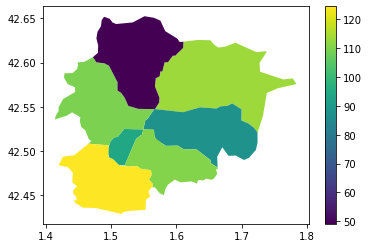

In [11]:
import matplotlib.pyplot as plt

links=gpd.GeoDataFrame(links, geometry='geometry', crs=4326)
data = gpd.sjoin(links, subdiv1)
sum_distance = data.groupby(['division_name']).sum()[['distance']].reset_index()
sum_distance.loc[:, 'distance'] /= 1000

fig, ax = plt.subplots(1, 1)
plot_data = subdivisions.merge(sum_distance, on='division_name')
plot_data.plot(column='distance', ax=ax, legend=True)

In [12]:
import matplotlib.pyplot as plt

if subdiv2.shape[0]:
    links=gpd.GeoDataFrame(links, geometry='geometry', crs=4326)
    data = gpd.sjoin(links, subdiv2)
    sum_distance = data.groupby(['division_name']).sum()[['distance']].reset_index()
    sum_distance.loc[:, 'distance'] /= 1000

    fig, ax = plt.subplots(1, 1)
    plot_data = subdivisions.merge(sum_distance, on='division_name')
    plot_data.plot(column='distance', ax=ax, legend=True)


# Map the car network DENSITY by zone

<AxesSubplot:>

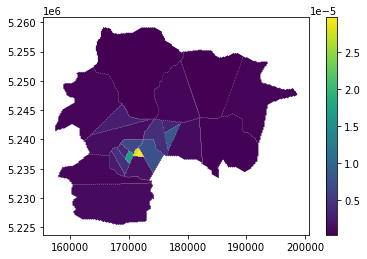

In [13]:
sql = "SELECT zone_id, Hex(ST_AsBinary(GEOMETRY)) as geom FROM zones;"
zones = gpd.GeoDataFrame.from_postgis(sql, project.conn, geom_col="geom", crs=4326)

data = gpd.sjoin(links, zones)
sum_distance = data.groupby(['zone_id']).sum()[['distance']].reset_index()
sum_distance.loc[:, 'distance'] /= 1000


fig, ax = plt.subplots(1, 1)
plot_data = zones.merge(sum_distance, on='zone_id')
plot_data= plot_data.to_crs(3857)

plot_data['link_density'] = plot_data['distance']/plot_data.geom.area

plot_data.plot(column='link_density', ax=ax, legend=True)

In [14]:
project.close()